In [4]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 11.0 MB/s 
     |████████████████████████████████| 788 kB 29.4 MB/s 
     |████████████████████████████████| 981 kB 16.4 MB/s 
     |████████████████████████████████| 5.8 MB 40.3 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 182 kB 11.3 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 19.7 MB 2.8 MB/s 
     |████████████████████████████████| 200 kB 51.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.5 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=7278541d75a958cfaf7a4053e48b48a54f0d92b31753968d4571beb04b804b69
  Stored in directory: /root/.cache/pip/wheels/3d/9f/9d/d806a20bd97bc7076d724fa3e69fa5be61836ba16b2ffa6126
  Created wh

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self

In [1]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import yfinance as yf

In [5]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-12-12 18:21:25,542 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp_yu66on8


100%|██████████| 265512723/265512723 [00:11<00:00, 23818450.31B/s]

2022-12-12 18:21:37,053 copying /tmp/tmp_yu66on8 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-12-12 18:21:37,849 removing temp file /tmp/tmp_yu66on8
2022-12-12 18:21:37,920 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
sentence = flair.data.Sentence("You suck")
sentiment_model.predict(sentence)
sentence

Sentence: "You suck" → NEGATIVE (0.9948)

In [7]:
import re
#using regex to clean up the tweet text
def clean(tweet):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    tesla = re.compile(r"(?i)@Tesla(?=\b)")
    user = re.compile(r"(?i)@[a-z0-9_]+")

    # we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    
    return tweet

In [ ]:
# read bearer token for authentication
with open('bearer_token.txt') as fp:
    BEARER_TOKEN = fp.read()

In [11]:
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAO7yjgEAAAAAZNLVli5WYGoamdcN0x96qJbV%2FeQ%3DaoghMiLGaZWB27NrA4ceHMHdsCrgyiKdmgQmQxgShGeeadGesw'

In [18]:
# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR TSLA) (lang:en)',
    'max_results': '10',
    'tweet.fields': 'created_at,lang'
}

In [14]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text']
    }
    return data

In [15]:
def getSentiment(tweetData):
    tweetData['text'] = clean(tweetData['text'])
    sentence = flair.data.Sentence(tweetData['text'])
    sentiment_model.predict(sentence)
    tweetData['probability'] = sentence.labels[0].score # numerical score 0-1
    tweetData['sentiment'] = sentence.labels[0].value # 'POSITIVE' or 'NEGATIVE')
    return tweetData


In [16]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)
    

In [20]:
df = pd.DataFrame()  # initialize dataframe to store tweets
now = datetime.now().replace(microsecond=0, second=0, minute=0) - timedelta(days=0) # get the current datetime and round down, this is our starting point
last_week = now - timedelta(days=2)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
intervals = 0

while True:
    # if we have reached 7 days ago, break the loop
    print(now)
    if datetime.strptime(now, dtformat) < last_week:
        break
    
    # get 60 minutes before 'now'
    pre60 = time_travel(now, 30)  
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    now = pre60  # move the window 60 minutes earlier
    
    if 'data' in response.json():
        for tweet in response.json()['data']:
            row = get_data(tweet)  # we defined this function earlier
            row = getSentiment(row)
            df = df.append(row, ignore_index=True)

    

2022-12-12T18:00:00Z
2022-12-12T17:30:00Z
2022-12-12T17:00:00Z
2022-12-12T16:30:00Z
2022-12-12T16:00:00Z
2022-12-12T15:30:00Z
2022-12-12T15:00:00Z
2022-12-12T14:30:00Z
2022-12-12T14:00:00Z
2022-12-12T13:30:00Z
2022-12-12T13:00:00Z
2022-12-12T12:30:00Z
2022-12-12T12:00:00Z
2022-12-12T11:30:00Z
2022-12-12T11:00:00Z
2022-12-12T10:30:00Z
2022-12-12T10:00:00Z
2022-12-12T09:30:00Z
2022-12-12T09:00:00Z
2022-12-12T08:30:00Z
2022-12-12T08:00:00Z
2022-12-12T07:30:00Z
2022-12-12T07:00:00Z
2022-12-12T06:30:00Z
2022-12-12T06:00:00Z
2022-12-12T05:30:00Z
2022-12-12T05:00:00Z
2022-12-12T04:30:00Z
2022-12-12T04:00:00Z
2022-12-12T03:30:00Z
2022-12-12T03:00:00Z
2022-12-12T02:30:00Z
2022-12-12T02:00:00Z
2022-12-12T01:30:00Z
2022-12-12T01:00:00Z
2022-12-12T00:30:00Z
2022-12-12T00:00:00Z
2022-12-11T23:30:00Z
2022-12-11T23:00:00Z
2022-12-11T22:30:00Z
2022-12-11T22:00:00Z
2022-12-11T21:30:00Z
2022-12-11T21:00:00Z
2022-12-11T20:30:00Z
2022-12-11T20:00:00Z
2022-12-11T19:30:00Z
2022-12-11T19:00:00Z
2022-12-11T18

In [21]:
df.head(30)

,id,created_at,text,probability,sentiment
0,1602362645469749248,2022-12-12T17:59:59.000Z,Tesla Haha bruh bought a bolt lol; pansy ass,0.803447,NEGATIVE
1,1602362644354080769,2022-12-12T17:59:59.000Z,"RT : Well, I WAS a Tesla customer. Just cancel...",0.999373,NEGATIVE
2,1602362644140363800,2022-12-12T17:59:59.000Z,Another partnership ends. First terminates j...,0.999227,NEGATIVE
3,1602362643783745536,2022-12-12T17:59:59.000Z,He literally knew in advance that he was going...,0.995372,NEGATIVE
4,1602362643175866368,2022-12-12T17:59:59.000Z,"RT : Oh, just another $25 billion in sharehold...",0.999630,NEGATIVE
5,1602362641841885186,2022-12-12T17:59:58.000Z,RT : The 10 greatest engineers of all time: 1....,0.999754,POSITIVE
6,1602362641329971200,2022-12-12T17:59:58.000Z,RT : I will never buy a Tesla. Anyone I know w...,0.991201,NEGATIVE
7,1602362638536773652,2022-12-12T17:59:58.000Z,"SpaceX, Tesla, Starlink, or boring, predictab...",0.999931,NEGATIVE
8,1602362637999697920,2022-12-12T17:59:58.000Z,"RT : In September, the Tesla factory's fire ...",0.947919,NEGATIVE
9,1602362637316231172,2022-12-12T17:59:57.000Z,"RT : And totally bizarre, since this is a lead...",0.752567,NEGATIVE


In [22]:
def changeTimeToDay(time):
    return datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ').replace(second=0)
    
df['created_at'] = df['created_at'].apply(changeTimeToDay)

In [23]:
def standardSentiment(sent):
    if sent == "POSITIVE":
        return 1
    else:
        return -1

df['standSentiment'] = df['sentiment'].apply(standardSentiment)

In [24]:
df.head(30)

,id,created_at,text,probability,sentiment,standSentiment
0,1602362645469749248,2022-12-12 17:59:00,Tesla Haha bruh bought a bolt lol; pansy ass,0.803447,NEGATIVE,-1
1,1602362644354080769,2022-12-12 17:59:00,"RT : Well, I WAS a Tesla customer. Just cancel...",0.999373,NEGATIVE,-1
2,1602362644140363800,2022-12-12 17:59:00,Another partnership ends. First terminates j...,0.999227,NEGATIVE,-1
3,1602362643783745536,2022-12-12 17:59:00,He literally knew in advance that he was going...,0.995372,NEGATIVE,-1
4,1602362643175866368,2022-12-12 17:59:00,"RT : Oh, just another $25 billion in sharehold...",0.999630,NEGATIVE,-1
5,1602362641841885186,2022-12-12 17:59:00,RT : The 10 greatest engineers of all time: 1....,0.999754,POSITIVE,1
6,1602362641329971200,2022-12-12 17:59:00,RT : I will never buy a Tesla. Anyone I know w...,0.991201,NEGATIVE,-1
7,1602362638536773652,2022-12-12 17:59:00,"SpaceX, Tesla, Starlink, or boring, predictab...",0.999931,NEGATIVE,-1
8,1602362637999697920,2022-12-12 17:59:00,"RT : In September, the Tesla factory's fire ...",0.947919,NEGATIVE,-1
9,1602362637316231172,2022-12-12 17:59:00,"RT : And totally bizarre, since this is a lead...",0.752567,NEGATIVE,-1


In [25]:
df_sentiment = df.groupby(['created_at']).mean()
df_sentiment = df_sentiment.reset_index()

In [26]:
df_sentiment

,created_at,probability,standSentiment
0,2022-12-10 17:59:00,0.778483,0.6
1,2022-12-10 18:29:00,0.890152,0.4
2,2022-12-10 18:59:00,0.929640,0.2
3,2022-12-10 19:29:00,0.919054,0.2
4,2022-12-10 19:59:00,0.921401,-0.8
...,...,...,...
92,2022-12-12 15:59:00,0.958901,0.0
93,2022-12-12 16:29:00,0.973524,0.0
94,2022-12-12 16:59:00,0.901104,-0.8
95,2022-12-12 17:29:00,0.966225,-1.0


In [31]:
def addMinute(time):
    return time + timedelta(minutes = 1)    
df_sentiment['created_at'] = df_sentiment['created_at'].apply(addMinute)

In [32]:
df_sentiment

,created_at,probability,standSentiment
0,2022-12-10 18:00:00,0.778483,0.6
1,2022-12-10 18:30:00,0.890152,0.4
2,2022-12-10 19:00:00,0.929640,0.2
3,2022-12-10 19:30:00,0.919054,0.2
4,2022-12-10 20:00:00,0.921401,-0.8
...,...,...,...
92,2022-12-12 16:00:00,0.958901,0.0
93,2022-12-12 16:30:00,0.973524,0.0
94,2022-12-12 17:00:00,0.901104,-0.8
95,2022-12-12 17:30:00,0.966225,-1.0


In [39]:
companie = yf.Ticker("TSLA")
stock = companie.history(
    start='2022-12-05',
    end= '2022-12-11',
    interval='30m'
).reset_index()
print(stock)

                    Datetime        Open        High         Low       Close  \
0  2022-12-05 09:30:00-05:00  189.100006  191.270004  185.500000  185.901993   
1  2022-12-05 10:00:00-05:00  185.839996  186.088196  183.800003  184.960007   
2  2022-12-05 10:30:00-05:00  184.960007  186.229904  184.039993  186.119995   
3  2022-12-05 11:00:00-05:00  186.100098  187.410004  185.160004  185.309998   
4  2022-12-05 11:30:00-05:00  185.320007  185.470001  184.110107  184.232101   
..                       ...         ...         ...         ...         ...   
60 2022-12-09 13:30:00-05:00  178.949997  180.570007  178.800003  180.440094   
61 2022-12-09 14:00:00-05:00  180.429993  181.669998  179.899994  181.304993   
62 2022-12-09 14:30:00-05:00  181.330002  181.639999  180.419998  180.970001   
63 2022-12-09 15:00:00-05:00  180.949997  181.270004  180.169998  180.370102   
64 2022-12-09 15:30:00-05:00  180.369995  180.759995  178.619995  179.029999   

      Volume  Dividends  Stock Splits  

In [40]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Datetime      65 non-null     datetime64[ns, America/New_York]
 1   Open          65 non-null     float64                         
 2   High          65 non-null     float64                         
 3   Low           65 non-null     float64                         
 4   Close         65 non-null     float64                         
 5   Volume        65 non-null     int64                           
 6   Dividends     65 non-null     int64                           
 7   Stock Splits  65 non-null     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(3)
memory usage: 4.2 KB


In [41]:
def changeToDay(time):
    time = time.to_pydatetime()
    return time.strftime('%Y-%m-%d %H:%M:%S')
    
stock['Datetime'] = stock['Datetime'].apply(changeToDay)

In [42]:
stock.head(20)

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-05 09:30:00,189.100006,191.270004,185.500000,185.901993,20289873,0,0
1,2022-12-05 10:00:00,185.839996,186.088196,183.800003,184.960007,11138701,0,0
2,2022-12-05 10:30:00,184.960007,186.229904,184.039993,186.119995,6896007,0,0
3,2022-12-05 11:00:00,186.100098,187.410004,185.160004,185.309998,6652751,0,0
4,2022-12-05 11:30:00,185.320007,185.470001,184.110107,184.232101,5099410,0,0
5,2022-12-05 12:00:00,184.240005,184.973007,183.699997,184.080002,3974607,0,0
6,2022-12-05 12:30:00,184.080002,184.229904,182.600006,183.039993,4852673,0,0
7,2022-12-05 13:00:00,183.009995,183.600006,182.450104,183.339996,4328947,0,0
8,2022-12-05 13:30:00,183.339996,183.990005,182.190002,182.279999,4029135,0,0
9,2022-12-05 14:00:00,182.279999,182.679993,181.820007,182.350006,4093606,0,0


In [43]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      65 non-null     object 
 1   Open          65 non-null     float64
 2   High          65 non-null     float64
 3   Low           65 non-null     float64
 4   Close         65 non-null     float64
 5   Volume        65 non-null     int64  
 6   Dividends     65 non-null     int64  
 7   Stock Splits  65 non-null     int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 4.2+ KB


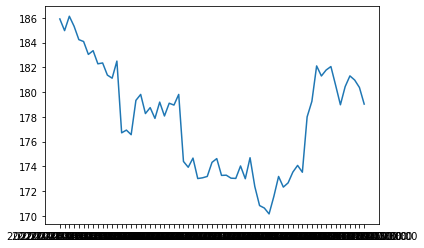

In [44]:
from matplotlib import pyplot as plt

plt.plot(stock['Datetime'], stock['Close'])
plt.show()

[*********************100%***********************]  1 of 1 completed


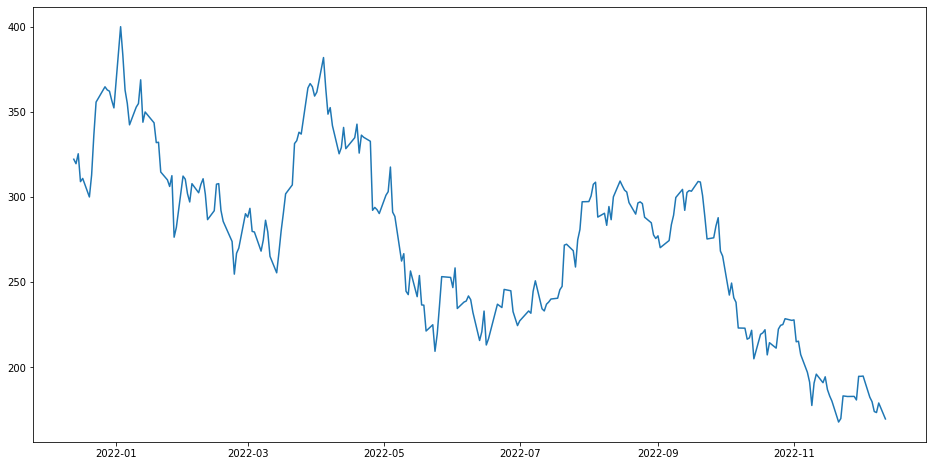

In [45]:
from datetime import date, timedelta
from matplotlib import pyplot as plt

Start = date.today() - timedelta(365)
Start.strftime('%Y-%m-%d')

End = date.today() + timedelta(2)
End.strftime('%Y-%m-%d')

def closing_price(ticker):
    Asset = pd.DataFrame(yf.download(ticker, start=Start,
      end=End)['Adj Close'])     
    return Asset

                                  
TSLA = closing_price('TSLA')      # CALL THE FUNCTION

plt.figure(figsize=(16,8))
plt.plot(TSLA)
plt.show()

In [46]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   created_at      97 non-null     datetime64[ns]
 1   probability     97 non-null     float64       
 2   standSentiment  97 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.4 KB


In [47]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      65 non-null     object 
 1   Open          65 non-null     float64
 2   High          65 non-null     float64
 3   Low           65 non-null     float64
 4   Close         65 non-null     float64
 5   Volume        65 non-null     int64  
 6   Dividends     65 non-null     int64  
 7   Stock Splits  65 non-null     int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 4.2+ KB


In [ ]:
stock['Datetime'] = pd.to_datetime(stock['Datetime'])

In [ ]:
df_final = pd.merge(df_sentiment, stock, how='inner', left_on = 'created_at', right_on = 'Datetime')

In [ ]:
df_final

,created_at,probability,standSentiment,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-05 09:30:00,0.938357,1.0,2022-12-05 09:30:00,93.050003,94.059998,92.660004,93.475601,9810568,0,0
1,2022-12-05 10:00:00,0.937460,0.6,2022-12-05 10:00:00,93.473900,93.473900,92.510002,92.684998,6210301,0,0
2,2022-12-05 10:30:00,0.949068,0.4,2022-12-05 10:30:00,92.681198,93.169998,92.449997,92.970100,4266744,0,0
3,2022-12-05 11:00:00,0.908805,0.8,2022-12-05 11:00:00,92.974998,93.330002,92.279999,92.400002,5062202,0,0
4,2022-12-05 11:30:00,0.916706,0.8,2022-12-05 11:30:00,92.400002,92.410004,91.930000,92.040001,4928954,0,0
...,...,...,...,...,...,...,...,...,...,...,...
61,2022-12-09 14:00:00,0.956358,0.6,2022-12-09 14:00:00,89.559998,89.677299,89.370003,89.574997,2646014,0,0
62,2022-12-09 14:30:00,0.898169,0.2,2022-12-09 14:30:00,89.572998,89.660004,89.430000,89.530098,2198655,0,0
63,2022-12-09 15:00:00,0.924789,0.6,2022-12-09 15:00:00,89.538002,89.750000,89.410004,89.489998,2682315,0,0
64,2022-12-09 15:30:00,0.948533,0.6,2022-12-09 15:30:00,89.485001,89.620003,88.779999,89.099998,6284193,0,0


In [ ]:
#df_final = df_final.set_index('Datetime')

In [ ]:
df_final

,created_at,probability,standSentiment,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-05 09:30:00,0.938357,1.0,2022-12-05 09:30:00,93.050003,94.059998,92.660004,93.475601,9810568,0,0
1,2022-12-05 10:00:00,0.937460,0.6,2022-12-05 10:00:00,93.473900,93.473900,92.510002,92.684998,6210301,0,0
2,2022-12-05 10:30:00,0.949068,0.4,2022-12-05 10:30:00,92.681198,93.169998,92.449997,92.970100,4266744,0,0
3,2022-12-05 11:00:00,0.908805,0.8,2022-12-05 11:00:00,92.974998,93.330002,92.279999,92.400002,5062202,0,0
4,2022-12-05 11:30:00,0.916706,0.8,2022-12-05 11:30:00,92.400002,92.410004,91.930000,92.040001,4928954,0,0
...,...,...,...,...,...,...,...,...,...,...,...
61,2022-12-09 14:00:00,0.956358,0.6,2022-12-09 14:00:00,89.559998,89.677299,89.370003,89.574997,2646014,0,0
62,2022-12-09 14:30:00,0.898169,0.2,2022-12-09 14:30:00,89.572998,89.660004,89.430000,89.530098,2198655,0,0
63,2022-12-09 15:00:00,0.924789,0.6,2022-12-09 15:00:00,89.538002,89.750000,89.410004,89.489998,2682315,0,0
64,2022-12-09 15:30:00,0.948533,0.6,2022-12-09 15:30:00,89.485001,89.620003,88.779999,89.099998,6284193,0,0


In [ ]:
data = df_final.drop('Stock Splits', axis=1)

In [ ]:
data = data.drop('Dividends', axis=1)

In [ ]:
data = data.drop('Datetime', axis=1)

In [ ]:
data = data.drop('probability', axis=1)

In [ ]:
data

,created_at,standSentiment,Open,High,Low,Close,Volume
0,2022-12-05 09:30:00,1.0,93.050003,94.059998,92.660004,93.475601,9810568
1,2022-12-05 10:00:00,0.6,93.473900,93.473900,92.510002,92.684998,6210301
2,2022-12-05 10:30:00,0.4,92.681198,93.169998,92.449997,92.970100,4266744
3,2022-12-05 11:00:00,0.8,92.974998,93.330002,92.279999,92.400002,5062202
4,2022-12-05 11:30:00,0.8,92.400002,92.410004,91.930000,92.040001,4928954
...,...,...,...,...,...,...,...
61,2022-12-09 14:00:00,0.6,89.559998,89.677299,89.370003,89.574997,2646014
62,2022-12-09 14:30:00,0.2,89.572998,89.660004,89.430000,89.530098,2198655
63,2022-12-09 15:00:00,0.6,89.538002,89.750000,89.410004,89.489998,2682315
64,2022-12-09 15:30:00,0.6,89.485001,89.620003,88.779999,89.099998,6284193


In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
training_data_len = math.ceil(len(data)* 0.8)
dataset_train = data.iloc[0:training_data_len, :]

In [ ]:
dataset_train

,created_at,standSentiment,Open,High,Low,Close,Volume
0,2022-12-05 09:30:00,1.0,93.050003,94.059998,92.660004,93.475601,9810568
1,2022-12-05 10:00:00,0.6,93.473900,93.473900,92.510002,92.684998,6210301
2,2022-12-05 10:30:00,0.4,92.681198,93.169998,92.449997,92.970100,4266744
3,2022-12-05 11:00:00,0.8,92.974998,93.330002,92.279999,92.400002,5062202
4,2022-12-05 11:30:00,0.8,92.400002,92.410004,91.930000,92.040001,4928954
5,2022-12-05 12:00:00,0.6,92.029999,92.064903,91.540001,91.570000,5065970
6,2022-12-05 12:30:00,0.8,91.574997,91.820000,91.199997,91.370003,4179280
7,2022-12-05 13:00:00,0.2,91.370003,91.949997,91.300003,91.720001,3607286
8,2022-12-05 13:30:00,1.0,91.724197,91.857201,91.144997,91.195000,3200871
9,2022-12-05 14:00:00,0.4,91.190002,91.470001,91.050003,91.239998,2889737


In [ ]:
dataNum = 6
timesteps = 2 #intraday price prediction
epochNum = 3

In [ ]:
training_set = dataset_train.iloc[:,1:dataNum+1].values

In [ ]:
training_set

array([[ 1.00000000e+00,  9.30500031e+01,  9.40599976e+01,
         9.26600037e+01,  9.34756012e+01,  9.81056800e+06],
       [ 6.00000000e-01,  9.34738998e+01,  9.34738998e+01,
         9.25100021e+01,  9.26849976e+01,  6.21030100e+06],
       [ 4.00000000e-01,  9.26811981e+01,  9.31699982e+01,
         9.24499969e+01,  9.29701004e+01,  4.26674400e+06],
       [ 8.00000000e-01,  9.29749985e+01,  9.33300018e+01,
         9.22799988e+01,  9.24000015e+01,  5.06220200e+06],
       [ 8.00000000e-01,  9.24000015e+01,  9.24100037e+01,
         9.19300003e+01,  9.20400009e+01,  4.92895400e+06],
       [ 6.00000000e-01,  9.20299988e+01,  9.20649033e+01,
         9.15400009e+01,  9.15699997e+01,  5.06597000e+06],
       [ 8.00000000e-01,  9.15749969e+01,  9.18199997e+01,
         9.11999969e+01,  9.13700027e+01,  4.17928000e+06],
       [ 2.00000000e-01,  9.13700027e+01,  9.19499969e+01,
         9.13000031e+01,  9.17200012e+01,  3.60728600e+06],
       [ 1.00000000e+00,  9.17241974e+01,  9.185

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set_scaled

array([[1.        , 0.92671087, 1.        , 1.        , 1.        ,
        0.66316742],
       [0.71428571, 1.        , 0.90247949, 0.97104218, 0.86334973,
        0.34966662],
       [0.57142857, 0.86294679, 0.85191344, 0.95945817, 0.91262775,
        0.18042732],
       [0.85714286, 0.91374305, 0.87853637, 0.92663999, 0.81409017,
        0.24969349],
       [0.85714286, 0.81432964, 0.72545834, 0.85907272, 0.7518666 ,
        0.23809064],
       [0.71428571, 0.75035846, 0.66803725, 0.78378327, 0.6706302 ,
        0.2500216 ],
       [0.85714286, 0.67169146, 0.62728787, 0.71814544, 0.63606214,
        0.1728112 ],
       [0.42857143, 0.63624924, 0.64891805, 0.73745164, 0.69655691,
        0.12300363],
       [1.        , 0.69748729, 0.63347771, 0.70752762, 0.60581409,
        0.08761419],
       [0.57142857, 0.6051283 , 0.5690518 , 0.68918909, 0.61359171,
        0.06052154],
       [0.71428571, 0.61295965, 0.54575737, 0.67953599, 0.59976527,
        0.12476293],
       [1.        , 0

In [ ]:
X_train = []
Y_train = []
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0:dataNum])    
    Y_train.append(training_set_scaled[i, 0])                        
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
Y_train

array([0.57142857, 0.85714286, 0.85714286, 0.71428571, 0.85714286,
       0.42857143, 1.        , 0.57142857, 0.71428571, 1.        ,
       0.71428571, 0.57142857, 0.57142857, 0.71428571, 0.85714286,
       0.42857143, 0.71428571, 0.85714286, 0.71428571, 0.28571429,
       1.        , 1.        , 0.57142857, 0.85714286, 0.85714286,
       0.85714286, 1.        , 0.57142857, 0.71428571, 0.57142857,
       1.        , 0.14285714, 0.42857143, 0.42857143, 0.71428571,
       0.42857143, 1.        , 0.71428571, 0.42857143, 0.28571429,
       0.85714286, 0.85714286, 0.        , 0.14285714, 0.28571429,
       0.42857143, 0.28571429, 0.42857143, 0.71428571, 0.42857143,
       0.85714286])

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], dataNum))

In [ ]:
X_train.shape

(51, 2, 6)

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 32, input_shape = (X_train.shape[1], dataNum), return_sequences = True))
regressor.add(LSTM(units = 16))
regressor.add(Dense(units = 1))

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 32)             4992      
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,145
Trainable params: 8,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor.fit(X_train, Y_train, batch_size = 32, epochs = epochNum)

Epoch 1/3
2/2 [==============================] - 3s 7ms/step - loss: 0.1841
Epoch 2/3
2/2 [==============================] - 0s 6ms/step - loss: 0.1680
Epoch 3/3
2/2 [==============================] - 0s 6ms/step - loss: 0.1534


In [ ]:
test_set = data.iloc[training_data_len: , :]

In [ ]:
test_set

,created_at,standSentiment,Open,High,Low,Close,Volume
53,2022-12-09 10:00:00,-0.2,89.555000,89.879997,88.959999,89.184998,6224219
54,2022-12-09 10:30:00,0.6,89.184998,89.919998,89.120003,89.894997,5119554
55,2022-12-09 11:00:00,0.0,89.894997,89.930000,89.339996,89.709999,4165959
56,2022-12-09 11:30:00,0.4,89.717300,89.879997,89.480003,89.656998,3709640
57,2022-12-09 12:00:00,0.6,89.660004,89.760002,89.340500,89.379898,2813101
58,2022-12-09 12:30:00,0.0,89.370003,89.849998,89.339996,89.540001,2569362
59,2022-12-09 13:00:00,0.2,89.535004,89.559998,88.945000,89.290001,3541154
60,2022-12-09 13:30:00,-0.4,89.290001,89.620003,89.250000,89.560898,2457598
61,2022-12-09 14:00:00,0.6,89.559998,89.677299,89.370003,89.574997,2646014
62,2022-12-09 14:30:00,0.2,89.572998,89.660004,89.430000,89.530098,2198655


In [ ]:
real_stock_price = test_set.iloc[:,1:dataNum+1].values
lenOfReal = len(real_stock_price)
inputs = real_stock_price
inputs = sc.transform(inputs)

In [ ]:
inputs_test = []
for i in range(timesteps, len(inputs)):
  inputs_test.append(inputs[i-timesteps:i, 0:dataNum])

In [ ]:
inputs_test

[array([[0.14285714, 0.32244657, 0.30449183, 0.28571344, 0.25839938,
         0.35087856],
        [0.71428571, 0.25847539, 0.31114756, 0.31660218, 0.38111772,
         0.25468753]]),
 array([[0.71428571, 0.25847539, 0.31114756, 0.31660218, 0.38111772,
         0.25468753],
        [0.28571429, 0.38122983, 0.31281181, 0.35907198, 0.34914219,
         0.17165125]]),
 array([[0.28571429, 0.38122983, 0.31281181, 0.35907198, 0.34914219,
         0.17165125],
        [0.57142857, 0.35050725, 0.30449183, 0.38610036, 0.33998127,
         0.13191632]]),
 array([[0.57142857, 0.35050725, 0.30449183, 0.38610036, 0.33998127,
         0.13191632],
        [0.71428571, 0.340601  , 0.2845259 , 0.35916919, 0.29208656,
         0.0538483 ]]),
 array([[0.71428571, 0.340601  , 0.2845259 , 0.35916919, 0.29208656,
         0.0538483 ],
        [0.28571429, 0.29046164, 0.29950034, 0.35907198, 0.31975921,
         0.03262422]]),
 array([[0.28571429, 0.29046164, 0.29950034, 0.35907198, 0.31975921,
         0.

In [ ]:
inputs_test = np.array(inputs_test)
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], dataNum))
predicted_stock_price = regressor.predict(inputs_test)
predicted_stock_price = np.pad(predicted_stock_price,((0,0),(0,dataNum-1)),'constant') 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = np.delete(predicted_stock_price, [1, 2, 3, 4], axis=1)

1/1 [==============================] - 4s 4s/step


In [ ]:
predicted_stock_price

array([[-3.6817047e-01,  2.1947030e+06],
       [-3.6693150e-01,  2.1947030e+06],
       [-3.6132461e-01,  2.1947030e+06],
       [-3.6271808e-01,  2.1947030e+06],
       [-3.6145800e-01,  2.1947030e+06],
       [-3.6132056e-01,  2.1947030e+06],
       [-3.6070165e-01,  2.1947030e+06],
       [-3.5992116e-01,  2.1947030e+06],
       [-3.6113882e-01,  2.1947030e+06],
       [-3.6061040e-01,  2.1947030e+06],
       [-3.6641496e-01,  2.1947030e+06]], dtype=float32)

In [ ]:
real_stock_price = test_set[timesteps:lenOfReal+1,1:2]

rmse = np.sqrt(np.mean(predicted_stock_price - real_stock_price)**2)
rmse

29.709317584335807

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(dataset_test)


X_test = []
Y_test = []
for i in range(timesteps, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-timesteps:i, 0:dataNum])    
    Y_test.append(test_set_scaled[i, 0])                        
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = np.pad(predicted_stock_price,((0,0),(0,dataNum-1)),'constant') 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 0s 23ms/step


In [ ]:
predicted_stock_price

array([[ 0.92718905, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.93400794, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.9412328 , -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.94234234, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.940364  , -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.93519956, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.93856746, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ],
       [ 0.94474816, -0.4       , 89.09      , 89.09      , 88.78      ,
        89.09      ,  0.        ]], dtype=float32)

In [ ]:
rmse = np.sqrt(np.mean(predicted_stock_price - Y_test)**2)
rmse

ValueError: operands could not be broadcast together with shapes (8,7) (8,) 